# E-prop training of dope RNN on hold task

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from disp import set_plot

print('Torch version:', torch.__version__)
print('Cuda available:', torch.cuda.is_available())

device = 'cuda' if  torch.cuda.is_available() else 'cpu'
print('Device:', device)  # tested on cpu and cuda

Torch version: 1.7.1
Cuda available: False
Device: cpu


### E-prop factorization of the loss gradient

$$\frac{dE}{dW_{ij}} = \sum_t \frac{dE}{d\hat{z}_i^t} \left[ \frac{\partial \hat{z}_i^t}{\partial W_{ij}} \right]_{local} = \sum_t \frac{dE}{d\hat{z}_i^t} e_{ij}^t$$

where

$$
e_{ij}^t = \left[ \frac{\partial \hat{z}_i^t}{\partial W_{ij}} \right]_{local} = \frac{\partial \hat{z}_i^t}{\partial \hat{x}_i^t} \sum_{t' \leq t}\frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \dots \frac{\partial \hat{x}_i^{t'+1}}{\partial \hat{x}_i^{t'}}
\frac{\partial \hat{x}_i^{t'}}{\partial W_{ij}}
$$


Or, in vector format (note that $\frac{dE}{d\mathbf{w}_i}$, $\mathbf{e}_i^t$, and $\boldsymbol{\epsilon}_i^t$ are all row vectors):

$$\frac{dE}{d\mathbf{w}_i} = \sum_t \frac{dE}{d\hat{z}_i^t} \left[ \frac{\partial \hat{z}_i^t}{\partial \mathbf{w}_i} \right]_{local} = \sum_t \frac{dE}{d\hat{z}_i^t} \mathbf{e}_i^t = \sum_t L_i^t \mathbf{e}_i^t$$

where

$$
\mathbf{e}_i^t = \left[ \frac{\partial \hat{z}_i^t}{\partial \mathbf{w}_i} \right]_{local} = \frac{\partial \hat{z}_i^t}{\partial \hat{x}_i^t} \sum_{t' \leq t}\frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \dots \frac{\partial \hat{x}_i^{t'+1}}{\partial \hat{x}_i^{t'}}
\frac{\partial \hat{x}_i^{t'}}{\partial \mathbf{w}_i}
= \frac{\partial \hat{z}_i^t}{\partial \hat{x}_i^t} \boldsymbol{\epsilon}_i^t
$$

with

$$
\boldsymbol{\epsilon}_i^t \equiv \sum_{t' \leq t}\frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \dots \frac{\partial \hat{x}_i^{t'+1}}{\partial \hat{x}_i^{t'}}
\frac{\partial \hat{x}_i^{t'}}{\partial \mathbf{w}_i}
$$

which can also be computed recursively:

$$
\boldsymbol{\epsilon}_i^1 = \frac{\partial \hat{x}_i^1}{\partial \mathbf{w}_i} \quad \quad \quad
\boldsymbol{\epsilon}_i^t = \frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \boldsymbol{\epsilon}_i^{t-1} + \frac{\partial \hat{x}_i^t}{\partial \mathbf{w}_i}
$$

In [5]:
# model params
D = 1
N = 2000
TAU = .01
G = 100

DT = .001

J_psi = G*torch.randn((N, D), device=device)
B = torch.eye(D, device=device)
C = torch.eye(D, device=device)

# smln params
x_0 = torch.tensor([[1.,]], device=device).T

def get_z(x):
    return 1*x

def advance(x, z, w_T, u):
    psi = (1 + torch.tanh(J_psi@z))*np.sqrt(2/N)
    x_next = x + DT/TAU*(-x + C@w_T@psi + B@u)
    return x_next

In [6]:
targs = [torch.tensor([1.], device=device), torch.tensor([-1.], device=device)]

def loss_fn(z_hats, targ):
    return torch.mean((z_hats[-1, :] - targ)**2)

## E-prop

We first study the ideal case (above), in which the factorization should reproduce the full BPTT gradient exactly. Set use_approx to True to see
approx e-prop (where learning signal is replaced with partial derivative).

In [7]:
lr = 0.01
nepoch = 400
# use_approx = False
use_approx = True

T = .06

IT = int(round(T/DT))
t = np.arange(0, IT+1, dtype=float)*DT

w_T_hat = (0.*torch.ones((D, N), device=device)).detach()
w_T_hat.requires_grad = True

w_T_hat_flats = np.nan*np.ones((nepoch, D*N))

z_hats_initial = []

losses = []

# make inputs
us = torch.zeros((IT+1, D), device=device)

for epoch in range(nepoch):
    # compute first terms (dE/dx_t) using autograd
    x_hats = [x_0.clone()]
    z_hats = [get_z(x_hats[0])]

    for ct in range(1, IT+1):
        x_hat = advance(x_hats[ct-1], z_hats[ct-1], w_T_hat, us[[ct], :].T)
        x_hat.retain_grad()

        z_hat = get_z(x_hat)
        z_hat.retain_grad()

        x_hats.append(x_hat)
        z_hats.append(z_hat)

    x_hats_cc = torch.cat(x_hats, dim=1).T
    z_hats_cc = torch.cat(z_hats, dim=1).T
    z_hats_cc.retain_grad()

    loss = loss_fn(z_hats_cc, targs[0])

    loss.backward(retain_graph=True)
    
    # get backprop grad
    bptt_grad = w_T_hat.grad.clone()

    # get learning signals (x_hats grad)
    Ls = [z_hat.grad for z_hat in z_hats]
    Ls_approx = [grad for grad in z_hats_cc.grad]

    w_T_hat.grad.zero_()

    ## get eligibility vectors
    evs = torch.zeros((IT+1, D, N), device=device)  # each row is an e-vector

    for ct in range(1, IT+1):
        partial_x_hat, _, partial_w_T_hat, _ = torch.autograd.functional.jacobian(advance, inputs=(x_hats[ct-1], z_hats[ct-1], w_T_hat, us[[ct], :].T))
        # loop over neurons
        for i in range(D):
            evs[ct, i, :] = partial_x_hat[i, i]*evs[ct-1, i, :] + partial_w_T_hat[i][i, :]

    # convert to eligibility traces
    ets = 1*evs  # special case for identity activation function

    # compute gradient
    e_prop_grad = torch.zeros((D, N), device=device)
    e_prop_grad_approx = torch.zeros((D, N), device=device)
    for ct in range(1, IT+1):
        e_prop_grad += Ls[ct][:, None]*ets[ct, i, :]
        e_prop_grad_approx += Ls_approx[ct][:, None]*ets[ct, i, :]

    with torch.no_grad():
        if use_approx:
            w_T_hat -= lr*e_prop_grad_approx
        else:
            w_T_hat -= lr*e_prop_grad

    losses.append(loss.item())
    w_T_hat_flats[epoch, :] = w_T_hat.detach().cpu().numpy().flatten()

    if epoch == 0:
        z_hats_initial.append(z_hats_cc.detach().cpu().numpy())
    elif epoch in [1, 5, 10]:
        print('Epoch', epoch)
        print('BPTT grad:', bptt_grad)
        print('Eprop grad:', e_prop_grad)
        print('Eprop grad approx:', e_prop_grad_approx)
        
fig, axs = plt.subplots(1, 3, figsize=(8, 3), tight_layout=True)
axs[0].plot(losses)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(w_T_hat_flats)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('w_hat')

axs[2].plot(t, z_hats_initial[0], c='b', ls='--')
axs[2].plot(t, z_hats_stack.detach().cpu().numpy(), c='b', ls='-')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('z_hat')

RuntimeError: output with shape [1, 2000] doesn't match the broadcast shape [1, 1, 2000]

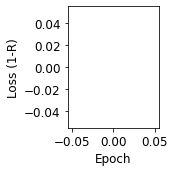

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), tight_layout=True)
ax.plot(losses)
set_plot(ax, x_label='Epoch', y_label='Loss (1-R)')

# if use_approx == False:
#     fig.savefig('ms/5_hold_loss_eprop.svg')
# else:
#     fig.savefig('ms/5_hold_loss_eprop_approx.svg')